In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./MNIST_DATA/',
    train=True,  # True -> training data, False -> testing data
    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


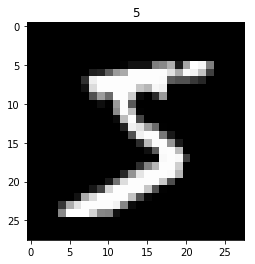

In [4]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [18]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./MNIST_DATA/', train=False,)
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

In [19]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [20]:
len(test_x)

2000

In [21]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [23]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = float(sum(pred_y == test_y)) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

Epoch:  0 | train loss: 2.2997 | test accuracy: 0.13
Epoch:  0 | train loss: 0.9877 | test accuracy: 0.55
Epoch:  0 | train loss: 0.5438 | test accuracy: 0.76
Epoch:  0 | train loss: 0.5431 | test accuracy: 0.83
Epoch:  0 | train loss: 0.2750 | test accuracy: 0.86
Epoch:  0 | train loss: 0.1532 | test accuracy: 0.90
Epoch:  0 | train loss: 0.4263 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1930 | test accuracy: 0.90
Epoch:  0 | train loss: 0.4212 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2155 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0811 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2922 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2020 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0873 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2653 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0775 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1521 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0742 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1353 | test accuracy